In [1]:
import os
import time
import numpy as np
import pandas as pd
import pickle as pkl
import nibabel as nib
from os.path import join as pjoin
from scipy.stats import sem
from sklearn.preprocessing import minmax_scale
from matplotlib import pyplot as plt
from magicbox.io.io import CiftiReader
from magicbox.algorithm.array import summary_across_col_by_mask
from magicbox.algorithm.plot import plot_bar
from cxy_visual_dev.lib.predefine import proj_dir, Atlas,\
    get_rois, mmp_map_file

anal_dir = pjoin(proj_dir, 'analysis')
work_dir = pjoin(anal_dir, 'plot/tmp')
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

# 画出HCPD, HCPYA, HCPA重叠年龄平均map的两两之间的散点图，观察能否找到两个数据集之间系统性误差的关系。

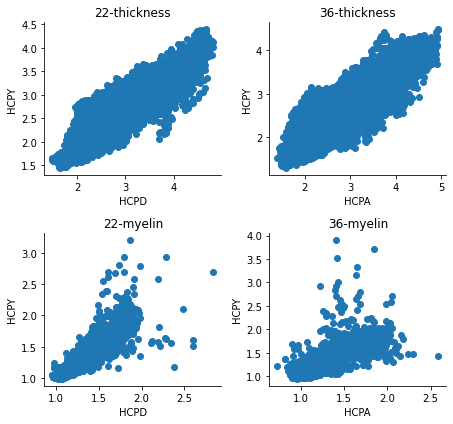

In [5]:
figsize = (6.4, 6)
meas_names = ('thickness', 'myelin')
meas_files = pjoin(proj_dir, 'analysis/structure/{0}_{1}_age-map-mean.dscalar.nii')
dataset_name_pairs = [('HCPD', 'HCPY'), ('HCPA', 'HCPY')]
trg_ages = ['22', '36']
_, axes = plt.subplots(len(meas_names), len(dataset_name_pairs), figsize=figsize)
for i, meas_name in enumerate(meas_names):
    for j, name_pair in enumerate(dataset_name_pairs):
        ax = axes[i, j]
        trg_age = trg_ages[j]
        meas_file1 = meas_files.format(name_pair[0], meas_name)
        meas_file2 = meas_files.format(name_pair[1], meas_name)
        reader1 = CiftiReader(meas_file1)
        reader2 = CiftiReader(meas_file2)
        idx1 = reader1.map_names().index(trg_age)
        idx2 = reader2.map_names().index(trg_age)
        map1 = reader1.get_data()[idx1]
        map2 = reader2.get_data()[idx2]
        ax.scatter(map1, map2)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel(f'{name_pair[0]}')
        ax.set_ylabel(f'{name_pair[1]}')
        ax.set_title(f'{trg_age}-{meas_name}')
plt.tight_layout()
plt.savefig(pjoin(work_dir, 'scatter_between_dataset_overlapping-age.jpg'))


# 用置换检验看重叠年龄平均map之间的欧氏距离是否异常，以及zscore能否通过这个考验。

In [2]:
meas_names = ('thickness', 'myelin')
dataset_name_pairs = [('HCPD', 'HCPY'), ('HCPA', 'HCPY')]
trg_ages = [22, 36]

## 置换检验

In [9]:
N = 10000  # 置换检验的迭代次数
# meas2dataset2file = {
#     'thickness': {
#         'HCPD': pjoin(proj_dir, 'data/HCP/HCPD_thickness.dscalar.nii'),
#         'HCPY': s1200_1096_thickness,
#         'HCPA': pjoin(proj_dir, 'data/HCP/HCPA_thickness.dscalar.nii')
#     },
#     'myelin': {
#         'HCPD': pjoin(proj_dir, 'data/HCP/HCPD_myelin.dscalar.nii'),
#         'HCPY': s1200_1096_myelin,
#         'HCPA': pjoin(proj_dir, 'data/HCP/HCPA_myelin.dscalar.nii')
#     }
# }
meas2dataset2file = {
    'thickness': {
        'HCPD': pjoin(proj_dir, 'data/HCP/HCPD_thickness_zscore.dscalar.nii'),
        'HCPY': pjoin(proj_dir, 'data/HCP/HCPY_thickness_zscore.dscalar.nii'),
        'HCPA': pjoin(proj_dir, 'data/HCP/HCPA_thickness_zscore.dscalar.nii')
    },
    'myelin': {
        'HCPD': pjoin(proj_dir, 'data/HCP/HCPD_myelin_zscore.dscalar.nii'),
        'HCPY': pjoin(proj_dir, 'data/HCP/HCPY_myelin_zscore.dscalar.nii'),
        'HCPA': pjoin(proj_dir, 'data/HCP/HCPA_myelin_zscore.dscalar.nii')
    }
}
out_file = pjoin(work_dir, 'permute_zscore.pkl')

out_data = {}
for meas_name in meas_names:
    out_data[meas_name] = {}
    for j, name_pair in enumerate(dataset_name_pairs):
        time1 = time.time()
        trg_age = trg_ages[j]
        meas_file1 = meas2dataset2file[meas_name][name_pair[0]]
        meas_file2 = meas2dataset2file[meas_name][name_pair[1]]
        info_file1 = dataset_name2info[name_pair[0]]
        info_file2 = dataset_name2info[name_pair[1]]
        df1 = pd.read_csv(info_file1)
        df2 = pd.read_csv(info_file2)
        maps1 = nib.load(meas_file1).get_fdata()[df1['age in years'] == trg_age]
        maps2 = nib.load(meas_file2).get_fdata()[df2['age in years'] == trg_age]

        n_map1 = maps1.shape[0]
        n_map2 = maps2.shape[0]
        idx_vec = np.r_[np.ones(n_map1, bool), np.zeros(n_map2, bool)]
        maps = np.r_[maps1, maps2]
        del maps1, maps2
        diffs = np.zeros(N + 1)
        for k in range(N + 1):
            map1 = np.mean(maps[idx_vec], 0)
            map2 = np.mean(maps[~idx_vec], 0)
            diffs[k] = np.linalg.norm(map1 - map2, ord=2)
            np.random.shuffle(idx_vec)
        out_data[meas_name][name_pair] = diffs
        print(f'Finish {meas_name}-{name_pair}, cost: {time.time() - time1} seconds.')

pkl.dump(out_data, open(out_file, 'wb'))

Finish thickness-('HCPD', 'HCPY'), cost: 467.1382460594177 seconds.
Finish thickness-('HCPA', 'HCPY'), cost: 80.02671980857849 seconds.
Finish myelin-('HCPD', 'HCPY'), cost: 479.2685351371765 seconds.
Finish myelin-('HCPA', 'HCPY'), cost: 66.7187340259552 seconds.


## 画图

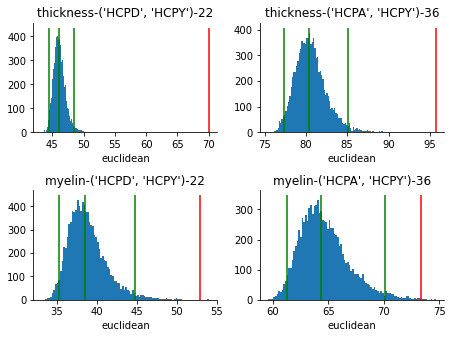

In [10]:
figsize = (6.4, 4.8)
data_file = pjoin(work_dir, 'permute_zscore.pkl')
data = pkl.load(open(data_file, 'rb'))
_, axes = plt.subplots(len(meas_names), len(dataset_name_pairs), figsize=figsize)
for i, meas_name in enumerate(meas_names):
    for j, name_pair in enumerate(dataset_name_pairs):
        ax = axes[i, j]
        diffs = data[meas_name][name_pair]
        vline_x1 = diffs[0]
        vline_x2 = np.percentile(diffs[1:], [2.5, 50, 97.5])
        ax.hist(diffs[1:], bins=100)
        ymin, ymax = ax.get_ylim()
        ax.vlines(vline_x1, ymin, ymax, colors='r')
        ax.vlines(vline_x2, ymin, ymax, colors='g')
        ax.set_xlabel('euclidean')
        ax.set_title(f'{meas_name}-{name_pair}-{trg_ages[j]}')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(pjoin(work_dir, 'permute_zscore.jpg'))

# 分背侧，中部和腹侧三条路把ROI按照C1值以及离枕极的距离(gdist)排布开来(C1是横轴，gdist是纵轴。中部路线gdist设置为0，背侧路线gdist归一化到(0, 1)，腹侧路线gdist归一化到(0, 1)后乘以-1)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


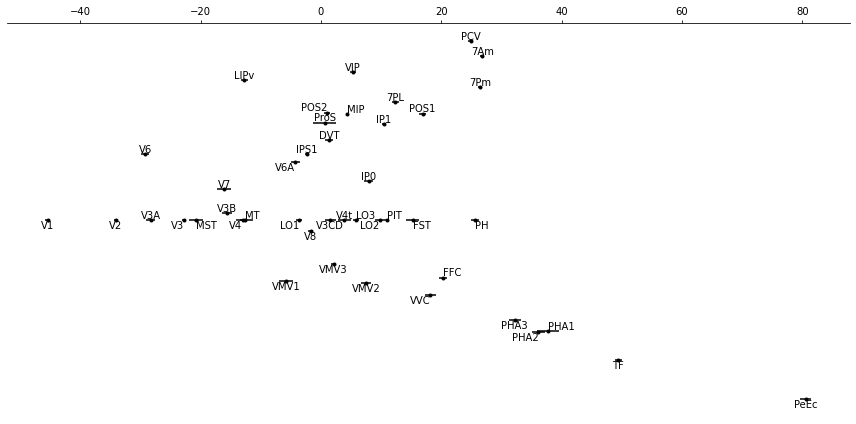

In [30]:
C1_fpath = pjoin(anal_dir, 'decomposition/HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj.dscalar.nii')
gdist_fpath = pjoin(anal_dir, 'gdist/gdist_src-OccipitalPole.dscalar.nii')
out_file = pjoin(work_dir, 'dorsal_middle_ventral1.jpg')

atlas = Atlas('HCP-MMP')
rois_dorsal = get_rois('MMP-vis3-G3') + get_rois('MMP-vis3-G16') +\
    get_rois('MMP-vis3-G17') + get_rois('MMP-vis3-G18')
rois_ventral = get_rois('MMP-vis3-G4') + get_rois('MMP-vis3-G13') +\
    get_rois('MMP-vis3-G14')
rois_middle = get_rois('MMP-vis3-G1') + get_rois('MMP-vis3-G2') +\
    get_rois('MMP-vis3-G5')

C1_map = nib.load(C1_fpath).get_fdata()[[0]]
gdist_map = nib.load(gdist_fpath).get_fdata()
n_roi_dorsal = len(rois_dorsal)
n_roi_ventral = len(rois_ventral)
n_roi_middle = len(rois_middle)

# prepare plot for dorsal
x1 = np.zeros(n_roi_dorsal, np.float64)
xerr1 = np.zeros(n_roi_dorsal, np.float64)
y1 = np.zeros(n_roi_dorsal, np.float64)
for roi_idx, roi in enumerate(rois_dorsal):
    mask = atlas.maps == atlas.roi2label[f'R_{roi}']
    C1_roi = C1_map[mask]
    x1[roi_idx] = np.mean(C1_roi)
    xerr1[roi_idx] = sem(C1_roi)
    y1[roi_idx] = np.mean(gdist_map[mask])
y1 = minmax_scale(y1)

# prepare plot for ventral
x2 = np.zeros(n_roi_ventral, np.float64)
xerr2 = np.zeros(n_roi_ventral, np.float64)
y2 = np.zeros(n_roi_ventral, np.float64)
for roi_idx, roi in enumerate(rois_ventral):
    mask = atlas.maps == atlas.roi2label[f'R_{roi}']
    C1_roi = C1_map[mask]
    x2[roi_idx] = np.mean(C1_roi)
    xerr2[roi_idx] = sem(C1_roi)
    y2[roi_idx] = np.mean(gdist_map[mask])
y2 = -minmax_scale(y2)

# prepare plot for middle
x3 = np.zeros(n_roi_middle, np.float64)
xerr3 = np.zeros(n_roi_middle, np.float64)
y3 = np.zeros(n_roi_middle, np.float64)
for roi_idx, roi in enumerate(rois_middle):
    mask = atlas.maps == atlas.roi2label[f'R_{roi}']
    C1_roi = C1_map[mask]
    x3[roi_idx] = np.mean(C1_roi)
    xerr3[roi_idx] = sem(C1_roi)

# prepare plot
x = np.concatenate([x1, x2, x3])
xerr = np.concatenate([xerr1, xerr2, xerr3])
y = np.concatenate([y1, y2, y3])
rois = rois_dorsal + rois_ventral + rois_middle

# plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.errorbar(x, y, xerr=xerr, ecolor='k', linestyle='', marker='.', mfc='k', mec='k')
for j, i, roi in zip(x, y, rois):
    if roi in ['V3', 'V4', 'LO1', 'PHA2', 'VVC', 'V6A', 'LO2']:
        ha, va = 'right', 'top'
    elif roi in ['MST', 'FST', 'PH']:
        ha, va = 'left', 'top'
    elif roi in ['MT', 'PHA1', 'FFC', 'MIP', 'LO3', 'PIT']:
        ha, va = 'left', 'bottom'
    elif roi in ['POS2']:
        ha, va = 'right', 'bottom'
    elif roi in ['V4t']:
        ha, va = 'center', 'bottom'
    elif roi in rois_dorsal:
        ha, va = 'center', 'bottom'
    else:
        ha, va = 'center', 'top'
    ax.text(j, i, roi, horizontalalignment=ha, verticalalignment=va)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(bottom=False, labelbottom=False, labelleft=False,
               left=False, top=True, labeltop=True)
fig.tight_layout()
fig.savefig(out_file)

# 分背侧，中部和腹侧三条路把ROI按照C1值排布开来(纵轴是C1值，横轴是C1值大小排序的序号。中部路线序号设置为0，背侧路线序号从-1开始往负方向递增，腹侧路线序号从1开始往正方向递增)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


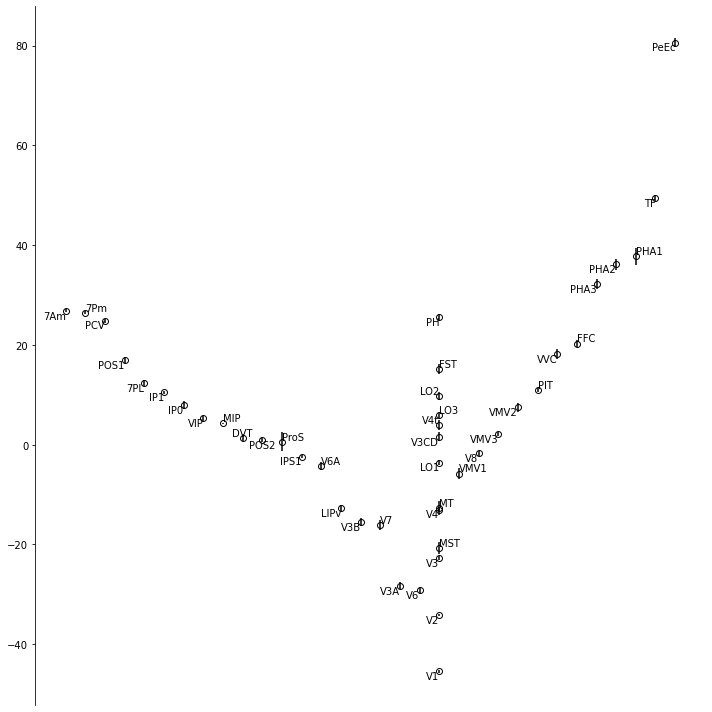

In [24]:
C1_fpath = pjoin(anal_dir, 'decomposition/HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj.dscalar.nii')
out_file = pjoin(work_dir, 'dorsal_middle_ventral2.jpg')

atlas = Atlas('HCP-MMP')
rois_dorsal = get_rois('MMP-vis3-G3') + get_rois('MMP-vis3-G16') +\
    get_rois('MMP-vis3-G17') + get_rois('MMP-vis3-G18')
rois_ventral = get_rois('MMP-vis3-G4') + get_rois('MMP-vis3-G13') +\
    get_rois('MMP-vis3-G14')
rois_middle = get_rois('MMP-vis3-G1') + get_rois('MMP-vis3-G2') +\
    get_rois('MMP-vis3-G5')

C1_map = nib.load(C1_fpath).get_fdata()[[0]]
n_roi_dorsal = len(rois_dorsal)
n_roi_ventral = len(rois_ventral)
n_roi_middle = len(rois_middle)

# prepare plot for dorsal
y1 = np.zeros(n_roi_dorsal, np.float64)
yerr1 = np.zeros(n_roi_dorsal, np.float64)
x1 = np.arange(-1, -n_roi_dorsal-1, -1)
for roi_idx, roi in enumerate(rois_dorsal):
    mask = atlas.maps == atlas.roi2label[f'R_{roi}']
    C1_roi = C1_map[mask]
    y1[roi_idx] = np.mean(C1_roi)
    yerr1[roi_idx] = sem(C1_roi)
rois_dorsal = np.array(rois_dorsal)
sort_indices1 = np.argsort(y1)
y1 = y1[sort_indices1]
yerr1 = yerr1[sort_indices1]
rois_dorsal = rois_dorsal[sort_indices1]

# prepare plot for ventral
y2 = np.zeros(n_roi_ventral, np.float64)
yerr2 = np.zeros(n_roi_ventral, np.float64)
x2 = np.arange(1, n_roi_ventral+1)
for roi_idx, roi in enumerate(rois_ventral):
    mask = atlas.maps == atlas.roi2label[f'R_{roi}']
    C1_roi = C1_map[mask]
    y2[roi_idx] = np.mean(C1_roi)
    yerr2[roi_idx] = sem(C1_roi)
rois_ventral = np.array(rois_ventral)
sort_indices2 = np.argsort(y2)
y2 = y2[sort_indices2]
yerr2 = yerr2[sort_indices2]
rois_ventral = rois_ventral[sort_indices2]

# prepare plot for middle
y3 = np.zeros(n_roi_middle, np.float64)
yerr3 = np.zeros(n_roi_middle, np.float64)
x3 = np.zeros(n_roi_middle)
for roi_idx, roi in enumerate(rois_middle):
    mask = atlas.maps == atlas.roi2label[f'R_{roi}']
    C1_roi = C1_map[mask]
    y3[roi_idx] = np.mean(C1_roi)
    yerr3[roi_idx] = sem(C1_roi)

# prepare plot
y = np.concatenate([y1, y2, y3])
yerr = np.concatenate([yerr1, yerr2, yerr3])
x = np.concatenate([x1, x2, x3])
rois = np.concatenate([rois_dorsal, rois_ventral, rois_middle])

# plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.errorbar(x, y, yerr=yerr, ecolor='k', linestyle='', marker='o', mfc=(1, 1, 1, 0), mec='k')
for j, i, roi in zip(x, y, rois):
    if roi in ['PHA1', 'FFC', 'MIP', 'LO3', 'PIT', 'V7', 'FST', 'MST', 'V6A', 'ProS', 'MT', '7Pm', 'VMV1']:
        ha, va = 'left', 'bottom'
    elif roi in ['LO2', 'V4t']:
        ha, va = 'right', 'bottom'
    elif roi in ['DVT']:
        ha, va = 'center', 'bottom'
    elif roi in ['POS2']:
        ha, va = 'center', 'top'
    else:
        ha, va = 'right', 'top'
    ax.text(j, i, roi, horizontalalignment=ha, verticalalignment=va)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(bottom=False, labelbottom=False)
fig.tight_layout()
fig.savefig(out_file)
# fig.show()

# 用HCPY-M+T_MMP-vis3-{Hemi}_zscore1_PCA-subj的PC1和PC2分别作为横轴和纵轴，用HCP MMP的分区颜色给每个点上色

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


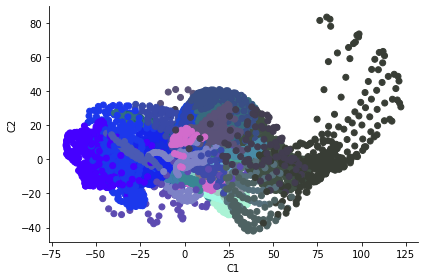

In [8]:
figsize = None
vis_name = 'MMP-vis3-R'
mask = Atlas('HCP-MMP').get_mask(get_rois(vis_name))[0]
pc_file = pjoin(
    anal_dir,
    f'decomposition/HCPY-M+T_{vis_name}_zscore1_PCA-subj.dscalar.nii')
out_file = pjoin(work_dir, 'PC1+2_predict_MMP.jpg')
# out_file = 'show'

pc_maps = nib.load(pc_file).get_fdata()[:2, mask]
reader = CiftiReader(mmp_map_file)
roi_map = reader.get_data()[0, mask]
lbl_tab = reader.label_tables()[0]
colors = [lbl_tab[i].rgba for i in roi_map]
colors = np.array(colors)

fig, ax = plt.subplots(figsize=figsize)
ax.scatter(pc_maps[0], pc_maps[1], c=colors)
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

# 用HCPY-M+T_MMP-vis3-{Hemi}_zscore1_PCA-subj的PC1和PC2分别作为x轴和y轴，用HCPYA的平均fALFF来做颜色映射

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


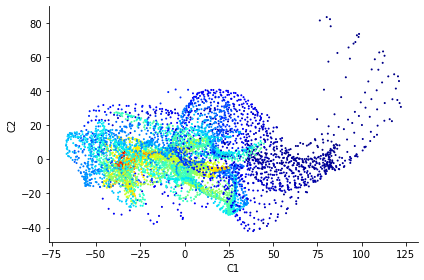

In [8]:
figsize = (12, 8)
figsize = None
vis_name = 'MMP-vis3-R'
mask = Atlas('HCP-MMP').get_mask(get_rois(vis_name))[0]
pc_file = pjoin(
    anal_dir,
    f'decomposition/HCPY-M+T_{vis_name}_zscore1_PCA-subj.dscalar.nii')
func_file = pjoin(anal_dir, 'summary_map/HCPY-falff_mean.dscalar.nii')

out_file = pjoin(work_dir, 'PC1+2_fit_fALFF.jpg')
# out_file = 'show'

pc_maps = nib.load(pc_file).get_fdata()[:2, mask]
func_map = nib.load(func_file).get_fdata()[0, mask]


fig, ax = plt.subplots(figsize=figsize)
ax.scatter(pc_maps[0], pc_maps[1], s=1, c=func_map, cmap='jet')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

# 统计MMP-vis3-{Hemi}各脑区的顶点数量

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


6747


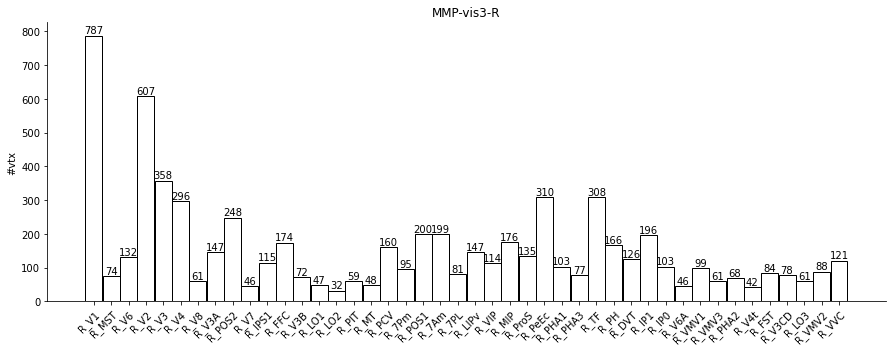

In [8]:
figsize = (12.5, 5)
vis_name = 'MMP-vis3-R'
atlas = Atlas('HCP-MMP')
mode = pjoin(work_dir, f'vtx_num_in_{vis_name}.jpg')
# mode = 'show'

rois = get_rois(vis_name)
y = np.zeros(len(rois), np.uint16)
for roi_idx, roi in enumerate(rois):
    y[roi_idx] = np.sum(atlas.maps[0] == atlas.roi2label[roi])
print(np.sum(y))

plot_bar(y, figsize=figsize, fc_ec_flag=True, fc=('w',), ec=('k',),
         show_height='', xticklabel=tuple(rois), rotate_xticklabel=True,
         ylabel='#vtx', title=vis_name, mode=mode)
